In [1]:
import os
import scipy.io as sio

AD = sio.loadmat("/kaggle/input/eeg-dataset/AD.mat")
MCI = sio.loadmat("/kaggle/input/eeg-dataset/MCI.mat")
Normal = sio.loadmat("/kaggle/input/eeg-dataset/normal.mat")

In [2]:
import numpy as np
AD_Data = []
for i in range(len(AD['AD'][0])):
  a = AD['AD'][0][i][0]
  data = np.transpose(a, (2, 0, 1))
  for j in range(data.shape[0]):
    AD_Data.append(data[j])

AD_Data = np.array(AD_Data)
AD_Data.shape

(1352, 4, 600)

In [3]:
MCI_Data = []
for i in range(len(MCI['MCI'][0])):
  a = MCI['MCI'][0][i][0]
  data = np.transpose(a, (2, 0, 1))
  for j in range(data.shape[0]):
    MCI_Data.append(data[j])

MCI_Data = np.array(MCI_Data)
MCI_Data.shape

(848, 4, 600)

In [4]:
Normal_Data = []
for i in range(len(Normal['normal'][0])):
  a = Normal['normal'][0][i][0]
  data = np.transpose(a, (2, 0, 1))
  for j in range(data.shape[0]):
    Normal_Data.append(data[j])

Normal_Data = np.array(Normal_Data)
Normal_Data.shape

(1677, 4, 600)

In [5]:
Data = []
label = []
for i in range(Normal_Data.shape[0]):
  Data.append(Normal_Data[i])
  label.append(0)

for j in range(MCI_Data.shape[0]):
  Data.append(MCI_Data[j])
  label.append(1)

for k in range(AD_Data.shape[0]):
  Data.append(AD_Data[k])
  label.append(2)

In [6]:
Data = np.array(Data)
label = np.array(label)
print(Data.shape)
print(label.shape)

(3877, 4, 600)
(3877,)


In [7]:
Ndata=[]
for i in  range(len(Data)):
    std=np.std(Data[i],axis=1)
    mean=np.mean(Data[i],axis=1)
    Data[i]=(Data[i].transpose()-mean.transpose()).transpose()
    Data[i]=(Data[i].transpose()/std.transpose()).transpose()
    Ndata.append(Data[i])

In [8]:
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

num_classes = 3
Y = to_categorical(label, num_classes)
x,y = shuffle(Data, Y, random_state = 2)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 2)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

2025-05-26 06:41:34.313418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748241694.809952      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748241694.941048      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Shape of X_train: (3489, 4, 600)
Shape of X_test: (388, 4, 600)
Shape of y_train: (3489, 3)
Shape of y_test: (388, 3)


In [9]:
# Reshape the input data
X_train = X_train.reshape((3489, 600, 4))
X_train.shape

(3489, 600, 4)

In [10]:
X_train = X_train.reshape(-1, 4, 600, 1)
X_test = X_test.reshape(-1, 4, 600, 1)
X_train.shape

(3489, 4, 600, 1)

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import sys,os,cv2
import tensorflow as tf
from keras.layers import Conv2D, Add, MaxPooling2D, AveragePooling2D, Activation, Dense, PReLU, Layer, DepthwiseConv2D
from keras.layers import Input, BatchNormalization, GlobalAveragePooling2D, Concatenate, Cropping2D, Multiply, Lambda, Flatten, Reshape
from keras.activations import relu, softmax, sigmoid, tanh,leaky_relu
from keras import initializers
from keras.models import Model
from keras.regularizers import l2
import keras.backend as K
import h5py

from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import load_model, Model

In [12]:
pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 63.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 59.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 94.4 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [25]:
import pennylane as qml
from pennylane import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Quantum circuit parameters
n_qubits = 2
n_layers = 1

dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev, interface='tf')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    # Additional quantum gates
    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.PauliZ(wires=1)
    #qml.Hadamard(wires=2)
    # qml.RX(0.5, wires=3)
    # qml.CNOT(wires=[1, 2])
    # qml.Toffoli(wires=[0, 1, 2])
    # qml.Hadamard(wires=3)

    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
# Define the QCNN model
def qcnn_model(input_shape, num_classes):
    model = Sequential()
    
    # Initial CNN layers
    model.add(Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu', padding='same',))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))
    model.add(Dropout(0.4))
    

    # Flatten and reduce to match qubits
    model.add(Flatten())
    model.add(Dense(n_qubits, activation='relu'))  # Reduce to n_qubits

    # Quantum layers
    weight_shapes = {"weights": (n_layers, n_qubits, 3)}
    model.add(qml.qnn.KerasLayer(quantum_circuit, weight_shapes=weight_shapes, output_dim=n_qubits))

    # Fully connected layers
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    return model
# Model configuration
input_shape = (4, 600, 1)  # Shape of the image input
num_classes = 3  # Number of classes for classification

model = qcnn_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 2, 300, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 1, 150, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 1, 150, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 1, 75, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 1, 38, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 1, 38, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 1, 19, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 1, 10, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 1, 10, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 2)                   │           2,562 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ keras_layer_6 (KerasLayer)           │ (None, 2)                   │               6 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 128)                 │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 96,011 (375.04 KB)

 Trainable params: 96,011 (375.04 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Training and Evaluation
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    patience=50,
    min_delta=0.001,
    monitor="val_accuracy",
    restore_best_weights=True
)

checkpoint = ModelCheckpoint('/kaggle/working/' + '-{epoch:02d}.keras', monitor='val_accuracy', save_best_only=True)

# Assuming X_train, y_train, X_test, y_test are already defined
history = model.fit(X_train, y_train, batch_size=16, epochs=200,
                    verbose=1, validation_data=(X_test, y_test), callbacks=[early_stopping, checkpoint], shuffle=True)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Epoch 1/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.4315 - loss: 1.0775 - val_accuracy: 0.4588 - val_loss: 1.0516
Epoch 2/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4740 - loss: 0.9972 - val_accuracy: 0.5644 - val_loss: 0.7676
Epoch 3/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5697 - loss: 0.7676 - val_accuracy: 0.6521 - val_loss: 0.5908
Epoch 4/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6262 - loss: 0.6266 - val_accuracy: 0.6804 - val_loss: 0.5568
Epoch 5/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6664 - loss: 0.5917 - val_accuracy: 0.5928 - val_loss: 0.7039
Epoch 6/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6637 - loss: 0.6421 - val_accuracy: 0.7139 - val_loss: 0.5429
Epoch 7/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6837 - loss: 0.5768 - val_accuracy: 0.7113 - val_loss: 0.5240
Epoch 8/200
219/219 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7147 - loss: 0.5442 - val_ac

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step


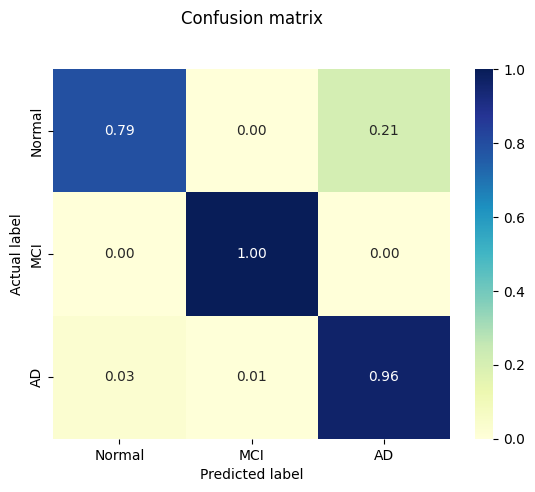

In [15]:
# Predictions
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
target_names = ['Normal', 'MCI', 'AD']
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
p = sns.heatmap(pd.DataFrame(cm), annot=True, xticklabels=target_names, yticklabels=target_names, cmap="YlGnBu", fmt='.2f')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('/kaggle/working/NCM_1.png', dpi=600)

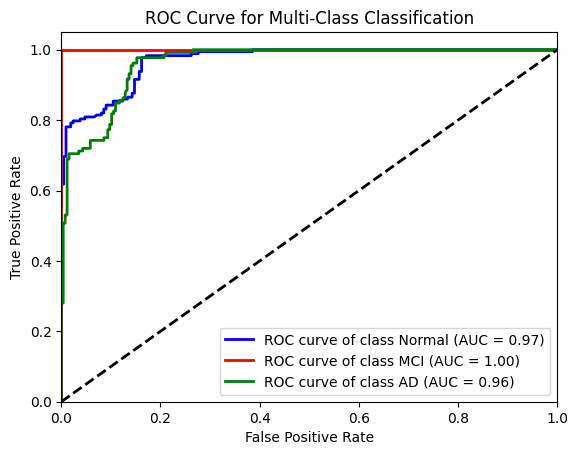

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
# Convert one-hot encoded y_test to class labels
y_true = np.argmax(y_test, axis=1)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(pred, axis=1)

# ROC Curve
n_classes = y_test.shape[1]  # Number of classes
y_test_bin = label_binarize(y_true, classes=np.arange(n_classes))  # Binarize y_true for ROC curve

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green']  # Adjust colors based on the number of classes
class_names = ['Normal', 'MCI', 'AD']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc="lower right")
plt.savefig('/kaggle/working/roc_curves1.png', dpi=600)
plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


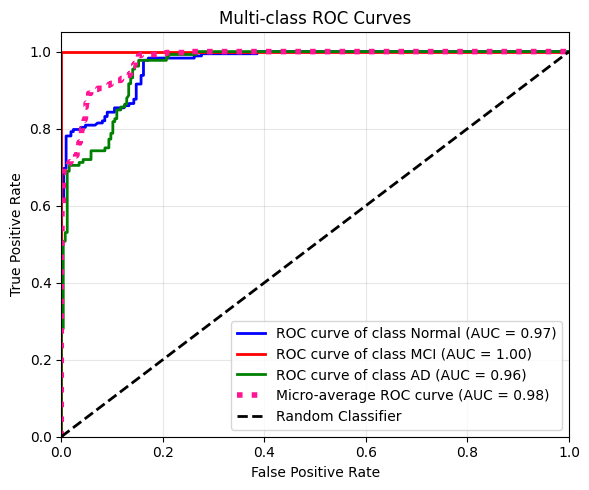

AUC Scores:
Normal: 0.969
MCI: 1.000
AD: 0.962
Micro-average: 0.978


In [17]:
# ROC Curve Analysis
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

# Get prediction probabilities
y_pred_proba = model.predict(X_test)

# Binarize the output for multi-class ROC
y_test_bin = label_binarize(y_true, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curves
plt.figure(figsize=(6, 5))
colors = cycle(['blue', 'red', 'green'])
class_names = ['Normal', 'MCI', 'AD']

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Save the plot
plt.tight_layout()
plt.savefig('/kaggle/working/roc_curves.png', dpi=600,)
plt.show()

# Print AUC scores
print("AUC Scores:")
for i in range(n_classes):
    print(f"{class_names[i]}: {roc_auc[i]:.3f}")
print(f"Micro-average: {roc_auc['micro']:.3f}")

Classification Report:
              precision    recall  f1-score   support

      Normal      0.972     0.792     0.873       178
         MCI      0.987     1.000     0.994        78
          AD      0.774     0.962     0.858       132

    accuracy                          0.892       388
   macro avg      0.911     0.918     0.908       388
weighted avg      0.908     0.892     0.892       388


Detailed Metrics Table:
    Class  Precision  Recall  F1-Score
   Normal      0.972   0.792     0.873
      MCI      0.987   1.000     0.994
       AD      0.774   0.962     0.858
Macro Avg      0.911   0.918     0.908
Micro Avg      0.892   0.892     0.892


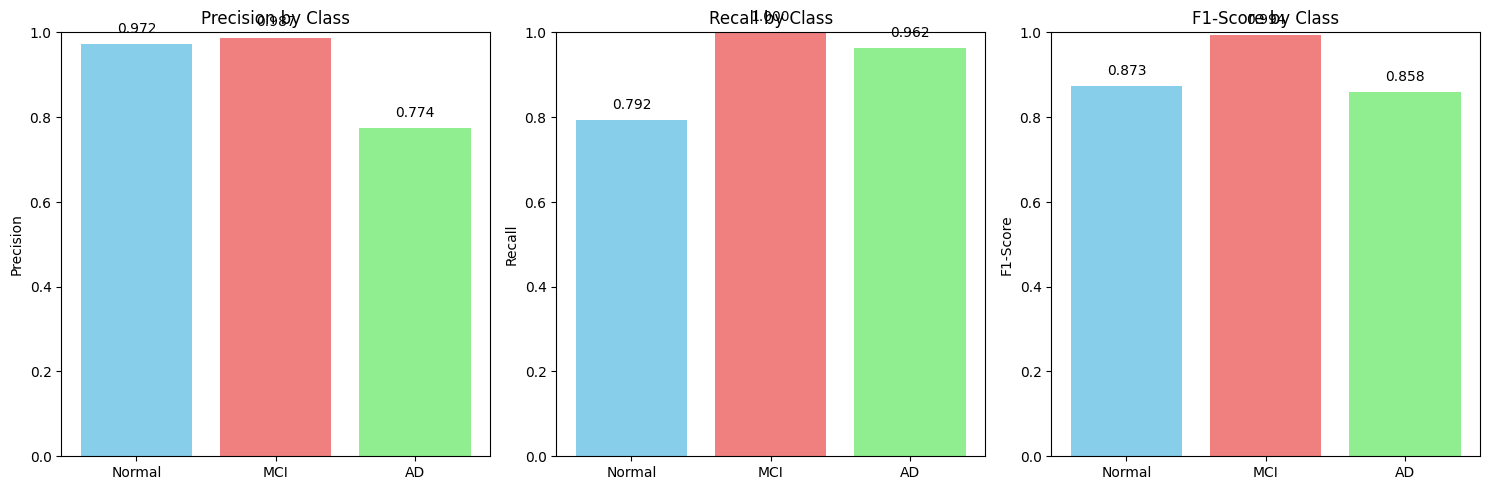

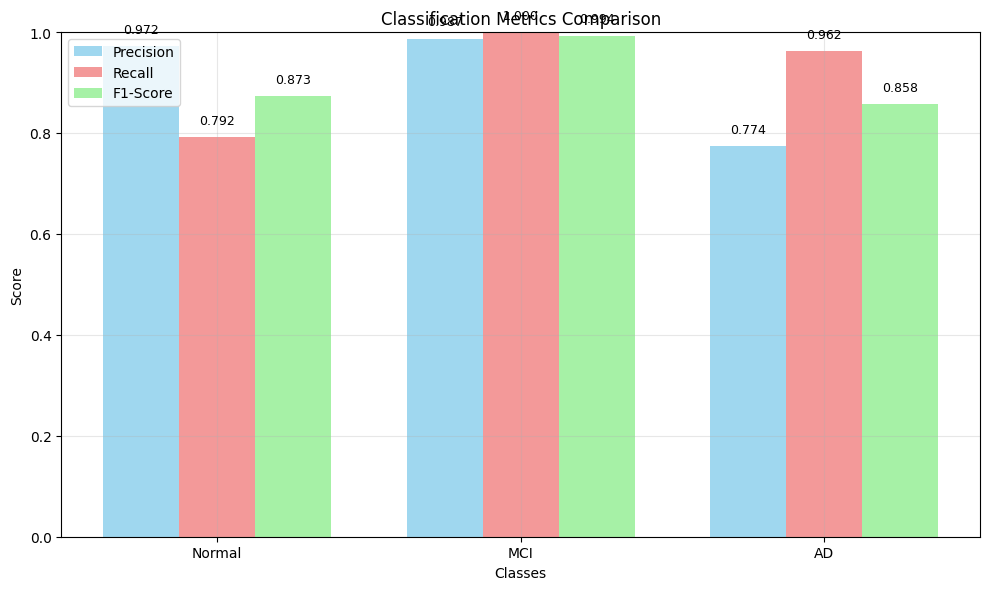


Summary Statistics:
Overall Accuracy: 0.892
Macro Average - Precision: 0.911, Recall: 0.918, F1: 0.908
Micro Average - Precision: 0.892, Recall: 0.892, F1: 0.892


In [18]:
# Classification Metrics: F1 Score, Precision, and Recall
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Class names
class_names = ['Normal', 'MCI', 'AD']

# Calculate individual metrics
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Calculate macro and micro averages
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')
f1_micro = f1_score(y_true, y_pred, average='micro')

# Print detailed classification report
print("Classification Report:")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# Create a detailed metrics table
metrics_data = {
    'Class': class_names + ['Macro Avg', 'Micro Avg'],
    'Precision': list(precision) + [precision_macro, precision_micro],
    'Recall': list(recall) + [recall_macro, recall_micro],
    'F1-Score': list(f1) + [f1_macro, f1_micro]
}

metrics_df = pd.DataFrame(metrics_data)
print("\nDetailed Metrics Table:")
print("=" * 50)
print(metrics_df.round(3).to_string(index=False))

# Visualize metrics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Precision bar plot
axes[0].bar(class_names, precision, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[0].set_title('Precision by Class')
axes[0].set_ylabel('Precision')
axes[0].set_ylim(0, 1)
for i, v in enumerate(precision):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

# Recall bar plot
axes[1].bar(class_names, recall, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[1].set_title('Recall by Class')
axes[1].set_ylabel('Recall')
axes[1].set_ylim(0, 1)
for i, v in enumerate(recall):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

# F1-Score bar plot
axes[2].bar(class_names, f1, color=['skyblue', 'lightcoral', 'lightgreen'])
axes[2].set_title('F1-Score by Class')
axes[2].set_ylabel('F1-Score')
axes[2].set_ylim(0, 1)
for i, v in enumerate(f1):
    axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('classification_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# Create a combined metrics visualization
plt.figure(figsize=(10, 6))
x = np.arange(len(class_names))
width = 0.25

plt.bar(x - width, precision, width, label='Precision', color='skyblue', alpha=0.8)
plt.bar(x, recall, width, label='Recall', color='lightcoral', alpha=0.8)
plt.bar(x + width, f1, width, label='F1-Score', color='lightgreen', alpha=0.8)

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Classification Metrics Comparison')
plt.xticks(x, class_names)
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for i in range(len(class_names)):
    plt.text(i - width, precision[i] + 0.02, f'{precision[i]:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i, recall[i] + 0.02, f'{recall[i]:.3f}', ha='center', va='bottom', fontsize=9)
    plt.text(i + width, f1[i] + 0.02, f'{f1[i]:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print(f"\nSummary Statistics:")
print("=" * 50)
print(f"Overall Accuracy: {(y_true == y_pred).mean():.3f}")
print(f"Macro Average - Precision: {precision_macro:.3f}, Recall: {recall_macro:.3f}, F1: {f1_macro:.3f}")
print(f"Micro Average - Precision: {precision_micro:.3f}, Recall: {recall_micro:.3f}, F1: {f1_micro:.3f}")

In [19]:
# FLOPs and MACs Calculation
import tensorflow as tf
import pandas as pd

def get_flops_and_macs(model):
    """Calculate FLOPs and MACs for the model"""
    
    # Get model operations
    concrete_func = tf.function(lambda x: model(x)).get_concrete_function(
        tf.TensorSpec(model.input_shape, model.input.dtype))
    
    # Calculate FLOPs using TensorFlow profiler
    from tensorflow.python.profiler.model_analyzer import profile
    from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
    
    # Profile the model
    opts = ProfileOptionBuilder.float_operation()
    flops = profile(concrete_func.graph, options=opts)
    
    if flops is None:
        total_flops = 0
    else:
        total_flops = flops.total_float_ops
    
    # MACs is typically FLOPs / 2 for most operations
    total_macs = total_flops // 2
    
    return total_flops, total_macs

# Calculate FLOPs and MACs
try:
    flops, macs = get_flops_and_macs(model)
    
    # Format numbers for readability
    def format_number(num):
        if num >= 1e9:
            return f"{num/1e9:.2f}G"
        elif num >= 1e6:
            return f"{num/1e6:.2f}M"
        elif num >= 1e3:
            return f"{num/1e3:.2f}K"
        else:
            return str(num)
    
    # Create results table
    results_table = pd.DataFrame({
        'Metric': ['FLOPs', 'MACs'],
        'Count': [flops, macs],
        'Formatted': [format_number(flops), format_number(macs)]
    })
    
    print("Model Computational Complexity:")
    print(results_table.to_string(index=False))
    
except Exception as e:
    print(f"Could not calculate FLOPs/MACs automatically: {e}")
    print("\nAlternative method - Manual calculation based on model summary:")
    
    # Get model parameters
    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    
    # Simple estimation (this is approximate)
    input_size = model.input_shape[1] if len(model.input_shape) > 1 else 1
    estimated_flops = total_params * input_size * 2  # Rough estimate
    estimated_macs = estimated_flops // 2
    
    def format_number(num):
        if num >= 1e9:
            return f"{num/1e9:.2f}G"
        elif num >= 1e6:
            return f"{num/1e6:.2f}M"
        elif num >= 1e3:
            return f"{num/1e3:.2f}K"
        else:
            return str(num)
    
    results_table = pd.DataFrame({
        'Metric': ['Parameters', 'Estimated FLOPs', 'Estimated MACs'],
        'Count': [total_params, estimated_flops, estimated_macs],
        'Formatted': [format_number(total_params), format_number(estimated_flops), format_number(estimated_macs)]
    })
    
    print("Model Complexity (Estimated):")
    print(results_table.to_string(index=False))

Could not calculate FLOPs/MACs automatically: The layer sequential has never been called and thus has no defined input.

Alternative method - Manual calculation based on model summary:
Model Complexity (Estimated):
         Metric  Count Formatted
     Parameters  96011    96.01K
Estimated FLOPs 768088   768.09K
 Estimated MACs 384044   384.04K


# *END***